In [23]:
import os
import random
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
DATASET_ROOT = r"M:/MVG/Courses/DeepLearning_TensorFlow_Keras/ProjectDataset/data"
ORIGINAL_TRAIN_DIR = os.path.join(DATASET_ROOT, "training")
TEST_DIR = os.path.join(DATASET_ROOT, "testing")

TRAIN_DIR = os.path.join(DATASET_ROOT, "train_split")
VAL_DIR = os.path.join(DATASET_ROOT, "val_split")

IMAGE_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 25

CLASSES = [
    "person", 
    "vest", 
    "helmet_blue", 
    "helmet_red", 
    "helmet_white",
    "helmet_yellow"
]

NUM_CLASSES = len(CLASSES)
CLASS_TO_ID = {cls: idx for idx, cls in enumerate(CLASSES)}
ID_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_ID.items()}

In [25]:
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

images = [f for f in os.listdir(ORIGINAL_TRAIN_DIR) if f.endswith('.jpg')]
random.shuffle(images)

split_index = int(0.8 * len(images))
train_images = images[:split_index]
val_images = images[split_index:]

In [26]:
def copy_pairs(file_list, target_dir):
    for img in file_list:
        xml = img.replace('.jpg', '.xml')

        shutil.copy(os.path.join(ORIGINAL_TRAIN_DIR, img), 
                    os.path.join(target_dir, img))
        shutil.copy(os.path.join(ORIGINAL_TRAIN_DIR, xml), 
                    os.path.join(target_dir, xml))
        
copy_pairs(train_images, TRAIN_DIR)
copy_pairs(val_images, VAL_DIR)

print(f"Total training images: {len(os.listdir(TRAIN_DIR)) // 2}")
print(f"Total validation images: {len(os.listdir(VAL_DIR)) // 2}")

Total training images: 1036
Total validation images: 388


In [27]:
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        label = obj.find("name").text
        if label not in CLASS_TO_ID:
            continue

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(CLASS_TO_ID[label])

    return boxes, labels

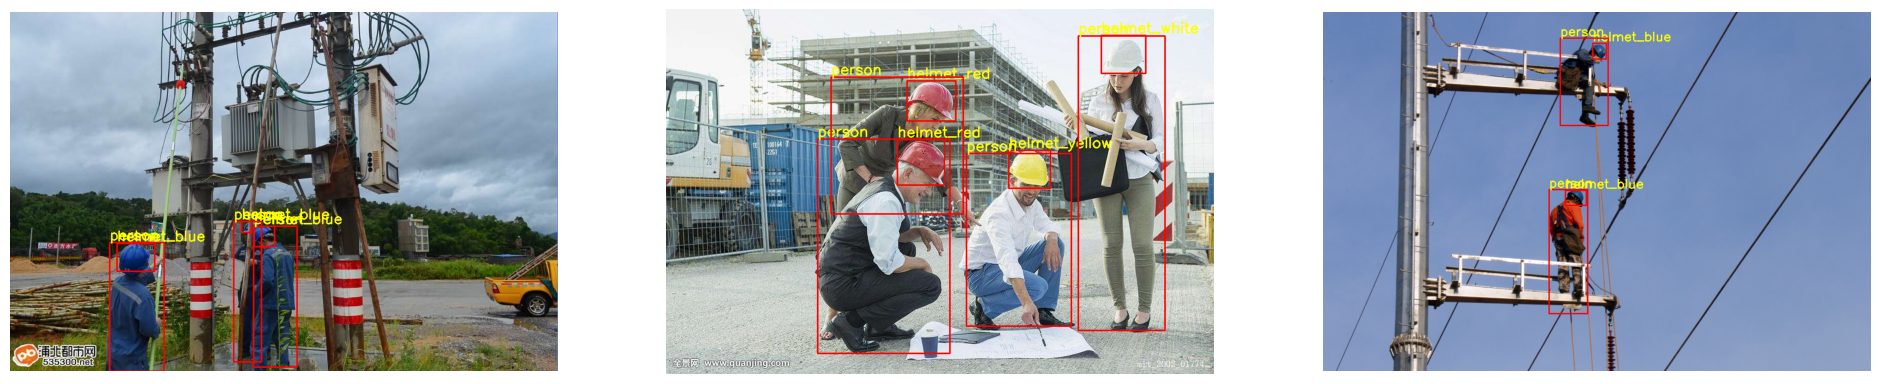

In [28]:
def plot_ground_truth(test_dir, num_images = 3):
    imgs = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
    chosen = random.sample(imgs, num_images)

    plt.figure(figsize=(24,10))

    for i, img_name in enumerate(chosen):
        img_path = os.path.join(test_dir, img_name)
        xml_path = img_path.replace('.jpg', '.xml')

        boxes, labels = parse_voc_xml(xml_path)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes, labels = parse_voc_xml(xml_path)

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(img, ID_TO_CLASS[label], 
                        (xmin, ymin - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

plot_ground_truth(TEST_DIR)

In [32]:
def load_data(directory):
    images = []
    boxes_list = []
    labels_list = []

    for file in os.listdir(directory):
        if not file.endswith('.jpg'):
            continue

        img_path = os.path.join(directory, file)
        xml_path = img_path.replace('.jpg', '.xml')

        img = cv2.imread(img_path)
        h, w, _ = img.shape
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = img / 255.0

        boxes, labels = parse_voc_xml(xml_path)
        if len(boxes) == 0:
            continue

        xmin, ymin, xmax, ymax = boxes[0]
        boxes_list.append([
            xmin / w,
            ymin / h,
            xmax / w,
            ymax / h
        ])
        labels_list.append(labels[0])
        images.append(img)

        # Data augmentation
        if np.random.rand() < 0.5:
            img_flipped = np.fliplr(img)

            # flip x coordinates
            boxes_list.append([
                1 - (xmax / w),
                ymin / h,
                1 - (xmin / w),
                ymax / h
            ])
            labels_list.append(labels[0])
            images.append(img_flipped)

    return (
        np.array(images, dtype=np.float32),
        {"boxes": np.array(boxes_list, dtype=np.float32),
         "class": np.array(labels_list, dtype=np.int32)}
    )

X_train, y_train = load_data(TRAIN_DIR)
X_val, y_val = load_data(VAL_DIR)

In [33]:
print("Images:", X_train.shape[0])
print("Boxes :", y_train["boxes"].shape[0])
print("Labels:", y_train["class"].shape[0])

Images: 1554
Boxes : 1554
Labels: 1554


In [34]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation="relu")(x)

bbox_out = layers.Dense(4, name='boxes')(x)
class_out = layers.Dense(NUM_CLASSES, activation='softmax', name='class')(x)

model = models.Model(inputs=inputs, outputs=[bbox_out, class_out])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 222, 222, 32)         896       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_10[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 109, 109, 64)         18496     ['max_pooling2d_7[0][0]'

In [35]:
model.compile(
    optimizer='adam',
    loss={
        'boxes': tf.keras.losses.Huber(delta=1.0),
        'class': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        "boxes": 0.1,
        "class": 1.0
    },
    metrics={'class': 'accuracy'}
)

log_dir = "logs/training"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tensorboard_callback]
)

%load_ext tensorboard
%tensorboard --logdir logs/training

Epoch 1/25
195/195 [==============================] - 37s 164ms/step - loss: 1.4724 - boxes_loss: 0.0324 - class_loss: 1.4692 - class_accuracy: 0.3707 - val_loss: 1.4966 - val_boxes_loss: 0.0235 - val_class_loss: 1.4943 - val_class_accuracy: 0.3836
Epoch 2/25
195/195 [==============================] - 27s 139ms/step - loss: 1.4519 - boxes_loss: 0.0296 - class_loss: 1.4489 - class_accuracy: 0.3771 - val_loss: 1.4636 - val_boxes_loss: 0.0282 - val_class_loss: 1.4607 - val_class_accuracy: 0.3836
Epoch 3/25
195/195 [==============================] - 28s 143ms/step - loss: 1.4400 - boxes_loss: 0.0236 - class_loss: 1.4376 - class_accuracy: 0.3925 - val_loss: 1.4488 - val_boxes_loss: 0.0231 - val_class_loss: 1.4465 - val_class_accuracy: 0.3887
Epoch 4/25
195/195 [==============================] - 28s 144ms/step - loss: 1.4217 - boxes_loss: 0.0214 - class_loss: 1.4196 - class_accuracy: 0.3938 - val_loss: 1.4574 - val_boxes_loss: 0.0198 - val_class_loss: 1.4555 - val_class_accuracy: 0.3990
Epoc

Reusing TensorBoard on port 6006 (pid 19968), started 0:26:55 ago. (Use '!kill 19968' to kill it.)

In [45]:
def inference_images(model, test_dir, num_images=3):
    images = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]
    selected = random.sample(images, num_images)

    plt.figure(figsize=(30, 12))

    for i, img_name in enumerate(selected):
        img_path = os.path.join(test_dir, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w, _ = img.shape

        inp = cv2.resize(img_rgb, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
        inp = np.expand_dims(inp, axis=0)

        bbox_pred, cls_pred = model.predict(inp, verbose=0)

        cls_id = np.argmax(cls_pred[0])
        confidence = np.max(cls_pred[0])

        x1 = int(bbox_pred[0][0] * w)
        y1 = int(bbox_pred[0][1] * h)
        x2 = int(bbox_pred[0][2] * w)
        y2 = int(bbox_pred[0][3] * h)

        x1 = max(0, min(w - 1, x1))
        y1 = max(0, min(h - 1, y1))
        x2 = max(0, min(w - 1, x2))
        y2 = max(0, min(h - 1, y2))

        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(
            img_rgb,
            f"{ID_TO_CLASS[cls_id]}: {confidence:.2f}",
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255,255,0),
            2
        )

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_rgb)
        plt.axis("off")

    plt.show()


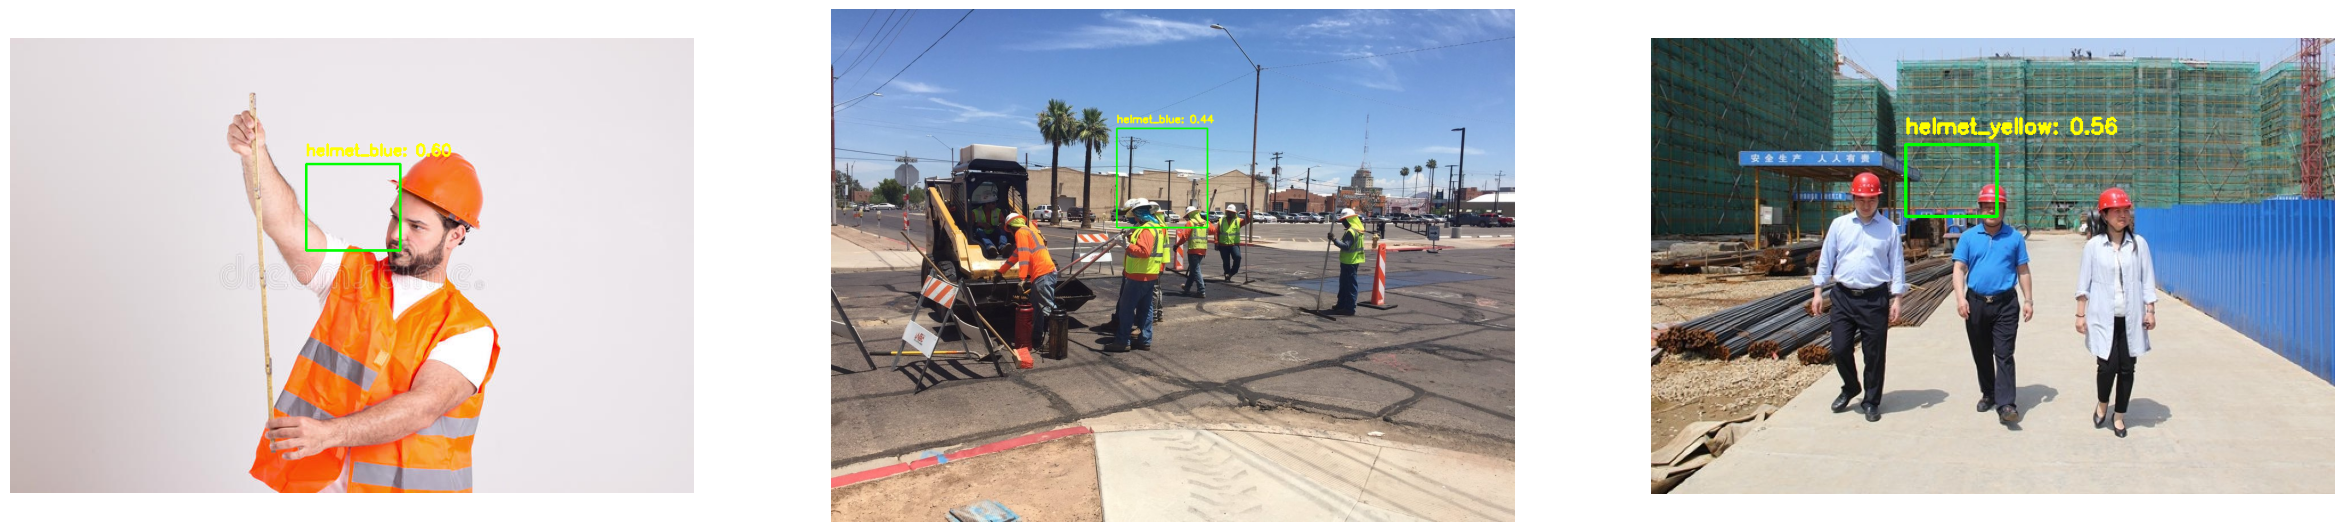

In [47]:
inference_images(model, TEST_DIR)

In [48]:
def compute_iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter = max(0, xi2-xi1) * max(0, yi2-yi1)
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])

    return inter / (area1 + area2 - inter + 1e-6)

In [51]:
def evaluate_voc(mode, test_dir, iou_thresh=0.5):
    ap_list = []

    for cls in range(NUM_CLASSES):
        tp, fp = 0, 0

        for file in os.listdir(test_dir):
            if not file.endswith(".jpg"):
                continue

            img_path = os.path.join(test_dir, file)
            xml_path = img_path.replace(".jpg", ".xml")

            img = cv2.imread(img_path)
            h, w, _ = img.shape

            gt_boxes, gt_labels = parse_voc_xml(xml_path)

            # Skip if class not present
            if cls not in gt_labels:
                continue

            inp = cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE))/255.0
            inp = np.expand_dims(inp, axis=0)

            bbox_pred, cls_pred = model.predict(inp, verbose=0)
            pred_cls = np.argmax(cls_pred[0])

            if pred_cls != cls:
                fp += 1
                continue

            pb = bbox_pred[0]
            pred_box = [
                int(pb[0] * w),
                int(pb[1] * h),
                int(pb[2] * w),
                int(pb[3] * h),
            ]

            # Compare with first GT box of this class
            gt_index = gt_labels.index(cls)
            gt_box = gt_boxes[gt_index]

            iou = compute_iou(pred_box, gt_box)

            if iou >= iou_thresh:
                tp += 1
            else:
                fp += 1

        ap = tp / (tp + fp) if (tp + fp) > 0 else 0
        print(f"Class {ID_TO_CLASS[cls]} AP: {ap:.2f}")
        ap_list.append(ap)

    mean_ap = np.mean(ap_list)
    print(f"\nMean Average Precision: {mean_ap:.2f}")

In [52]:
evaluate_voc(model, TEST_DIR)

Class person AP: 0.00
Class vest AP: 0.00
Class helmet_blue AP: 0.00
Class helmet_red AP: 0.00
Class helmet_white AP: 0.01
Class helmet_yellow AP: 0.00

Mean Average Precision: 0.00


In [53]:
from IPython.display import YouTubeVideo, display

In [65]:
def video_read_write(video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)
    
    # Check if camera opened successfully
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #frames_per_second = video.get(cv2.CAP_PROP_FPS)
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    if frames_per_second == 0 or frames_per_second is None:
        frames_per_second = 25.0
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])
    
    output_file = cv2.VideoWriter(
        filename=output_fname,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=float(frames_per_second),
        frameSize=(width, height),
        isColor=True,
    )
    
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            # ...Perform your processing

            # ---------- PREPROCESS FRAME ----------
            input_frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
            input_frame = input_frame / 255.0
            input_frame = np.expand_dims(input_frame, axis=0)

            # ---------- MODEL PREDICTION ----------
            bbox_pred, cls_pred = model.predict(input_frame, verbose=0)

            cls_id = np.argmax(cls_pred[0])
            confidence = np.max(cls_pred[0])

            # x1, y1, x2, y2 = bbox_pred[0].astype(int)
            h, w, _ = frame.shape
            pb = bbox_pred[0]

            x1 = int(pb[0] * w)
            y1 = int(pb[1] * h)
            x2 = int(pb[2] * w)
            y2 = int(pb[3] * h)

            x1 = max(0, min(w - 1, x1))
            y1 = max(0, min(h - 1, y1))
            x2 = max(0, min(w - 1, x2))
            y2 = max(0, min(h - 1, y2))

            # ---------- DRAW BOUNDING BOX ----------
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(
                frame,
                f"{ID_TO_CLASS[cls_id]}: {confidence:.2f}",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255,255,0),
                2
            )

            # ---------- OBJECT COUNT ----------
            counts = {c: 0 for c in CLASSES}
            counts[ID_TO_CLASS[cls_id]] += 1

            y_offset = 30
            for cls_name, count in counts.items():
                cv2.putText(
                    frame,
                    f"{cls_name}: {count}",
                    (10, y_offset),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0,0,255),
                    2
                )
                y_offset += 25
                
            # Then write the processed frame to the output file. 
            output_file.write(frame[:, ::-1, :])
            
            i += 1
        else:
            break
        
    video.release()
    output_file.release()
    
    return

In [66]:
video_path = "M:/MVG/Courses/DeepLearning_TensorFlow_Keras/Project4/Project_4_evaluation_video.mp4"
video_read_write(video_path)

In [ ]:
# https://youtu.be/6LJ-3RTEbiE
    
video = YouTubeVideo("-3RTEbiE", width=640, height=360)
display(video)